In [17]:
# Install and import libraries
!pip install pandas xlwings
import pandas as pd
import math
import numpy as np
from scipy.optimize import curve_fit
from scipy.optimize._numdiff import approx_derivative

In [19]:
# Data import
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
sheet_name = "DS_Calibration"
data_degr = pd.read_excel(file_path, sheet_name=sheet_name, usecols="A,D:F,H", skiprows=1)
data_degr = data_degr[data_degr.iloc[:, 0].str.contains("D-PP-", na=False)]
print(data_degr)

# Known variables
k_degr_i_j = data_degr.iloc[:, 1].values
s = data_degr.iloc[:, 2].values
I_j = data_degr.iloc[:, 3].values
C_j = data_degr.iloc[:, 4].values
print(I_j)

'''
x_i, tau_i, y_i, theta_i, z_i, eta_i (float): Empirical constants for polymer i
s (float): Surface area to volume ratio [cm^-1]
I_j (float): UV intensity in compartment j [W/m^2]
C_j (float): Microbial concentration in compartment j [CFU/ml]
k_degr_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j
'''

     D.P.I.  k [i,j] [d-1]  s [cm-1]  I_j [W/m2]  C_j [CFU/ml]
9   D-PP-01       4.39e-04  1.81e+01    1.12e+01      0.00e+00
10  D-PP-02       2.80e-04  1.95e+04    2.22e+00      0.00e+00
11  D-PP-03       1.34e-03  2.50e+01    0.00e+00      1.24e+09
12  D-PP-04       9.17e-04  3.00e+02    0.00e+00      1.50e+09
13  D-PP-05       1.02e-03  2.40e+01    0.00e+00      1.24e+09
14  D-PP-06       1.74e-03  4.40e+01    0.00e+00      1.77e+08
15  D-PP-07       1.13e-03  4.00e+02    0.00e+00      1.06e+10
16  D-PP-08       3.78e-05  4.03e+02    0.00e+00      4.00e+06
17  D-PP-09       7.62e-04  4.40e+01    1.40e+01      7.20e+01
18  D-PP-10       8.72e-05  1.50e+01    1.65e+00      2.50e+04
[11.17  2.22  0.    0.    0.    0.    0.    0.   14.    1.65]


'\nx_i, tau_i, y_i, theta_i, z_i, eta_i (float): Empirical constants for polymer i\ns (float): Surface area to volume ratio [cm^-1]\nI_j (float): UV intensity in compartment j [W/m^2]\nC_j (float): Microbial concentration in compartment j [CFU/ml]\nk_degr_i_j (float): The calculated degradation rate constant [d^-1] for polymer i in compartment j\n'

In [21]:
# Model definition (linear popt, log params_std)
def RC_degr(params, s, I_j, C_j):
    x_i, tau_i, y_i, theta_i, z_i, eta_i = params
    return x_i * (s**tau_i) * (y_i * (I_j**theta_i) + z_i * (C_j**eta_i))

# Log-space curve fitting (more suitable for rate constants spanning orders of magnitude)
def log_model_degr(inputs, x_i, tau_i, y_i, theta_i, z_i, eta_i):
    s, I_j, C_j = inputs
    params = [x_i, tau_i, y_i, theta_i, z_i, eta_i]
    k_degr = RC_degr(params, s, I_j, C_j)
    return np.log(k_degr)
    
# Prepare inputs (X) and outputs (Y) arrays
X = (s, I_j, C_j)
Y = np.log(k_degr_i_j)

# Fitting settings (Initial guesses, bounds, convergence threshold, maximum iterations)
initial_guess = [1, 1, 1, 1, 1, 1]
bounds = ([0]*6, [np.inf]*6) # Lower and upper bounds
tolerance = 0.001  # 0.1%
max_iterations = 1000

lower_bounds = [0, 0, 0, 0, 0, 0]  # Lower bounds: Set manually
upper_bounds = [np.inf] * len(initial_guess)  # Upper bounds: Infinity

# The loop for iterations
for iteration in range(max_iterations):
    # Perform curve fitting (maxfev: maximum function evaluations, which is calculated as: maxfev=200×(number of parameters + 1)
    # Fit log-transformed model to log-transformed data
    popt, pcov = curve_fit(log_model_degr, X, Y, p0=initial_guess, bounds=bounds, maxfev=2000)
    # Calculate the relative difference
    relative_diff = np.abs(popt - initial_guess) / np.abs(initial_guess)
    # Update the initial guess
    initial_guess = popt
    # Check for convergence
    if np.all(relative_diff < tolerance):
        print(f"Converged after {iteration + 1} iterations.")
        break
else:
    print("Reached the maximum number of iterations without full convergence.")

# Fitted parameters (i.e., parameter estimates), in linear space
parameter_names = ['x_i', 'tau_i', 'y_i', 'theta_i', 'z_i', 'eta_i']
for name, value in zip(parameter_names, popt):
    print(f"{name}: {value}")

Converged after 4 iterations.
x_i: 0.0035558264897857872
tau_i: 0.001523636484294322
y_i: 0.024840328751800214
theta_i: 0.7611915798764318
z_i: 2.7119204111942377e-05
eta_i: 0.44085549284618475


In [23]:
# Compute determination coefficient (R^2) while fully staying in log-space
# Step 1: Compute log-observed and log-predicted
eps = 1e-10  # Small constant to avoid log(0) issues
log_obs = np.log(k_degr_i_j + eps)  # Avoid log(0)
log_pred = log_model_degr(X, *popt)  # Already log(k_pred)


# Step 2: Compute SS_res and SS_tot in log-space
ss_res_log = np.sum((log_obs - log_pred)**2)
ss_tot_log = np.sum((log_obs - np.mean(log_obs))**2)

# Step 3: Compute R² in log-space
r_squared_log = 1 - (ss_res_log / ss_tot_log)
print(f"Log-space R² (pseudo-R²): {r_squared_log:.3f}")

Log-space R² (pseudo-R²): 0.726


In [25]:
# Save fitted parameters back to Excel (without modifying)
import xlwings as xw

# File path and sheet details
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
sheet_name = "Drop-down lists"
start_row = 20  # Change for other polymer types (17-26)
start_col = "C"

# Fitted parameters
fitted_parameters = popt

# Start the Excel application and open the workbook
app = xw.App(visible=True)  # Set visible=True to open the file automatically
workbook = app.books.open(file_path)
sheet = workbook.sheets[sheet_name]

# Write the fitted parameters to the specified cells
for i, value in enumerate(fitted_parameters):
    column = chr(ord(start_col) + i)
    cell = f"{column}{start_row}"
    sheet.range(cell).value = value

# Save the workbook
workbook.save()
workbook.close()
app.quit()

In [27]:
# Compute the Fisher Information Matrix (also fully in log-space)
from scipy.optimize._numdiff import approx_derivative

# Step 1: Define the wrapped model for Jacobian estimation
def wrapped_model(params):
    return log_model_degr(X, *params)

# Step 2: Compute residuals and estimated variance
residuals = Y - wrapped_model(popt)  # log of observed data (Y) - log of model output
sigma2 = np.var(residuals, ddof=1)  # Change to ddof=len(popt) when the number of available data points >> empirical constants

# Step 3: Compute the Jacobian at fitted parameters (sensitivity matrix)
J = approx_derivative(wrapped_model, popt, method='cs')

# Step 4: Compute Fisher Information Matrix (round to 3 significant digits)
FIM = (1 / sigma2) * J.T @ J

# Step 5: Compute standard deviations from the inverse of FIM
# cov_est = np.linalg.inv(FIM)
cov_est = np.linalg.pinv(FIM) # Uses the Moore–Penrose pseudo-inverse to avoid numerical instability or singularity issues
param_std = np.sqrt(np.diag(cov_est))

# Step 6: Compute relative uncertainty (in linear space, with param_std back-transformed)
param_names = ['x_i', 'tau_i', 'y_i', 'theta_i', 'z_i', 'eta_i']
relative_uncertainty = 100 * (np.abs(popt) * np.sqrt(np.expm1(param_std**2)) / np.abs(popt))  # Fixes the 0.00e+00 issue

# Format all values as strings with 3 significant digits
summary_df = pd.DataFrame({
    'Parameter': param_names,
    'Estimate': popt,
    'Std. Dev (σ)': param_std,
    'Relative Uncertainty (%)': relative_uncertainty
})

# --- Output ---
pd.set_option('display.float_format', '{:.2e}'.format)
print("Inverse of Fisher Information Matrix (parameter covariance matrix):")
print(np.array2string(cov_est, formatter={'float_kind': lambda x: f"{x:.2e}"}))
print("\nStandard deviations of parameter estimates (Cramér–Rao bounds): See the table below")
print("📋 Relative Uncertainty Table:")
print(summary_df.to_string(index=False))
print("\nNumber of residuals:", len(residuals))

Inverse of Fisher Information Matrix (parameter covariance matrix):
[[1.21e-05 -2.75e-04 1.73e-06 -1.08e-03 -6.46e-08 1.17e-05]
 [-2.75e-04 1.13e-02 -3.94e-05 1.49e-02 5.38e-07 2.67e-04]
 [1.73e-06 -3.94e-05 2.48e-07 -1.54e-04 -9.26e-09 1.69e-06]
 [-1.08e-03 1.49e-02 -1.54e-04 1.46e-01 7.37e-06 -1.78e-03]
 [-6.46e-08 5.38e-07 -9.26e-09 7.37e-06 4.05e-09 -6.57e-06]
 [1.17e-05 2.67e-04 1.69e-06 -1.78e-03 -6.57e-06 1.19e-02]]

Standard deviations of parameter estimates (Cramér–Rao bounds): See the table below
📋 Relative Uncertainty Table:
Parameter  Estimate  Std. Dev (σ)  Relative Uncertainty (%)
      x_i  3.56e-03      3.48e-03                  3.48e-01
    tau_i  1.52e-03      1.06e-01                  1.07e+01
      y_i  2.48e-02      4.98e-04                  4.98e-02
  theta_i  7.61e-01      3.83e-01                  3.97e+01
      z_i  2.71e-05      6.37e-05                  6.37e-03
    eta_i  4.41e-01      1.09e-01                  1.09e+01

Number of residuals: 10


In [29]:
# Save standard deviations and relative uncertainty of fitted parameters back to Excel (without modifying)
import xlwings as xw

cols_to_write = ['Estimate', 'Std. Dev (σ)', 'Relative Uncertainty (%)']
data_to_write = summary_df[cols_to_write].values.tolist()

wb = xw.Book('/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx')  # Use full path if not in working directory
ws = wb.sheets['Uncertainty']

start_cell = 'C45'  # Change this index for other polymers
ws.range(start_cell).value = data_to_write

wb.save()
wb.close()

     D.P.I. R.E.S. k_model [d-1] k [i,j] [d-1]
9   D-PP-01     UV      5.57e-04      4.39e-04
10  D-PP-02     UV      1.65e-04      2.80e-04
11  D-PP-03     MC      9.89e-04      1.34e-03
12  D-PP-04     MC      1.08e-03      9.17e-04
13  D-PP-05     MC      9.89e-04      1.02e-03
14  D-PP-06     MC      4.20e-04      1.74e-03
15  D-PP-07     MC      2.56e-03      1.13e-03
16  D-PP-08     MC      7.92e-05      3.78e-05
17  D-PP-09  UV+MC      6.63e-04      7.62e-04
18  D-PP-10  UV+MC      1.38e-04      8.72e-05


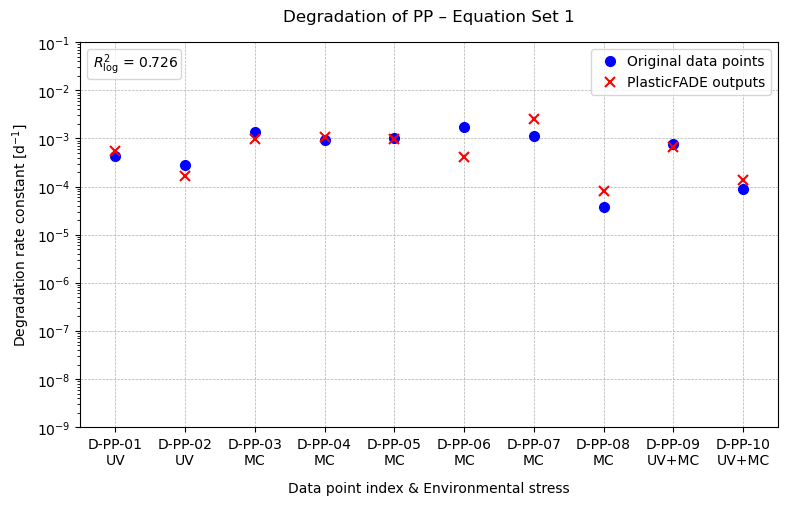

In [31]:
# Plot the modeling results with the original data points in the same graph
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Import the original data points and calculated RCs from PlasticFADE
import matplotlib.pyplot as plt
file_path = "/Users/elchulito/Library/CloudStorage/OneDrive-polymtlus/0 - A_Database and methodology_PhD/PlasticFADE.xlsx"
data_comp = pd.read_excel(file_path, sheet_name="Scatterplot", usecols="A:D", skiprows=5)  # change usecols for different polymers
data_comp = data_comp[data_comp.iloc[:, 0].str.contains("D-PP-", na=False)]
pd.set_option('display.float_format', '{:.2e}'.format)
print(data_comp)

fig, ax = plt.subplots(figsize=(9, 5))
df = pd.DataFrame(data_comp)
df['x_labels'] = df['D.P.I.'] + '\n' + df['R.E.S.']

# Plot original data and model output
ax.plot(df['D.P.I.'], df['k [i,j] [d-1]'], 'bo', markersize=7, label='Original data points')
ax.plot(df['D.P.I.'], df['k_model [d-1]'], 'rx', markersize=7, markeredgewidth=1.5, label='PlasticFADE outputs')

# Main legend
main_legend = ax.legend(loc='upper right', handletextpad=0.2)
ax.add_artist(main_legend)  # keep it when adding another legend

# --- Create second legend entry for R² without marker ---
r2_label = f'$R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'

# Make an invisible Line2D object (no line, no marker)
empty_line = Line2D([], [], color='none')

# Add the second legend with zero padding before the text
r2_legend = ax.legend([empty_line], [r2_label], loc='upper left', frameon=True, handlelength=0, handletextpad=0.2, borderpad=0.2)

plt.xticks(df['D.P.I.'], df['x_labels'])
plt.xlim(-0.5, len(data_comp) - 0.5)
ax.set_xlabel('Data point index & Environmental stress', labelpad=10)
ax.set_ylabel('Degradation rate constant [d$^{-1}$]')
ax.set_yscale('log')
ax.set_ylim(1e-9, 1e-1)
ax.grid(True, which="major", ls="--", lw=0.5)
ax.set_title('Degradation of PP – Equation Set 1', pad=15)

plt.savefig("/Users/elchulito/D_PP_S1_final.png", dpi=600, bbox_inches='tight')
plt.show()

In [ ]:
# --- Create second legend entry for both R² and log R²
# r2_label = f'$R^2$ = {r_squared:.3f}, $R_{{\\mathrm{{log}}}}^2$ = {r_squared_log:.3f}'